In [1]:
from pathlib import Path
cwd_path = Path.cwd()
# Parameters
# ! Change values
dataset = "CIFAR10" # CIFAR10, CIFAR100, SVHN
v_type = "mingd" # mingd, rand
root_path = str(cwd_path.parent / "files") # ! Path for features parent folder
params_path = str(cwd_path.parent / "src") # ! Path for python code?
split_index = 500

print(cwd_path)


/data/weijing/author-DI/ssim_notebook


In [2]:
from IPython.display import display, Markdown
v_type2disp = dict(mingd="MinGD", rand="Blind Walk")
display(Markdown(f"# {dataset} - {v_type2disp[v_type]} results"))

# CIFAR10 - MinGD results

In [3]:
import os, sys
sys.path.insert(0, params_path)

import argparse, time # ! `params` module import removed due to not found
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from importlib import reload
from tqdm.auto import tqdm

import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [4]:
import seaborn as sns
import pandas as pd
import os

In [5]:
from scipy.stats import combine_pvalues, ttest_ind_from_stats, ttest_ind
from functools import reduce
from scipy.stats import hmean

## Use the full vectors to train a linear model

In [6]:
root = os.path.join(root_path, dataset)
model_types = [ # ! Unused variable
    # 'zero-shot',
    # 'prune',
    'fine-tune',
    'extract-label',
    'extract-logit',
    'distillation',
    'teacher',
]


In [7]:
if v_type == "mingd" and dataset == "CIFAR100": v_type = "topgd"
    
# names = [ # ! Remove non available features
#     "teacher",
#     "distillation",
#     "extract-label",
#     "extract-logit",
#     # "zero-shot",
#     "fine-tune",
#     "pre-act-18",
#     "independent",
# ]
# trains = {}
# tests = {}
# for name in names:
#     trains[name] = (torch.load(f"{root}/model_{name}_normalized/train_{v_type}_vulnerability_2.pt")) # ! Change pt name
#     tests[name] = (torch.load(f"{root}/model_{name}_normalized/test_{v_type}_vulnerability_2.pt")) # ! Change pt name
# mean_cifar = trains["teacher"].mean(dim = (0,1))
# std_cifar = trains["teacher"].std(dim = (0,1))

In [8]:
# ! Change feature loading implementation
name__path_map = {
    "teacher": cwd_path.parent / "_reproduce_files_01/CIFAR10/model_teacher_normalized", # victim
    "independent": cwd_path.parent / "_reproduce_files_01/CIFAR10/model_independent_normalized",
    "0.09": cwd_path.parent / "ssim_files/CIFAR10-CIFAR10/model_teacher_normalized_0.09",
    "0.17": cwd_path.parent / "ssim_files/CIFAR10-CIFAR10/model_teacher_normalized_0.17",
    "0.34": cwd_path.parent / "ssim_files/CIFAR10-CIFAR10/model_teacher_normalized_0.34",
    "0.4": cwd_path.parent / "ssim_files/CIFAR10-CIFAR10/model_teacher_normalized_0.4",
}
names = list(name__path_map.keys())
trains = {}
tests = {}
for name, path in name__path_map.items():
    trains[name] = (torch.load(f"{path}/train_{v_type}_vulnerability_2.pt")) # ! Change pt name
    tests[name] = (torch.load(f"{path}/test_{v_type}_vulnerability_2.pt")) # ! Change pt name
mean_cifar = trains["teacher"].mean(dim = (0,1))
std_cifar = trains["teacher"].std(dim = (0,1))

In [9]:
if v_type == "mingd":
    for name in names:
        trains[name] = trains[name].sort(dim = 1)[0]
        tests[name] = tests[name].sort(dim = 1)[0]
        
for name in names:
    trains[name] = (trains[name]- mean_cifar)/std_cifar
    tests[name] = (tests[name]- mean_cifar)/std_cifar
    
f_num = 30
a_num=30

trains_n = {}
tests_n = {}
for name in names:
    trains_n[name] = trains[name].T.reshape(1000,f_num)[:,:a_num]
    tests_n[name] = tests[name].T.reshape(1000,f_num)[:,:a_num]

In [10]:
n_ex = split_index
train = torch.cat((trains_n["teacher"][:n_ex], tests_n["teacher"][:n_ex]), dim = 0)
y = torch.cat((torch.zeros(n_ex), torch.ones(n_ex)), dim = 0)

rand=torch.randperm(y.shape[0])
train = train[rand]
y = y[rand]

In [11]:
model = nn.Sequential(nn.Linear(a_num,100),nn.ReLU(),nn.Linear(100,1),nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr=0.1)

In [12]:
with tqdm(range(1000)) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        inputs = train
        outputs = model(inputs)
        loss = -1 * ((2*y-1)*(outputs.squeeze(-1))).mean()
        loss.backward()
        optimizer.step()
        pbar.set_description('loss {}'.format(loss.item()))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
# ! Save model
regressor_output_parent_dir_path = cwd_path / "regressor"
regressor_output_parent_dir_path.mkdir(exist_ok=True)
regressor_output_path = regressor_output_parent_dir_path / f"{dataset}_{v_type}_regressor.pt"
torch.save(model.state_dict(), regressor_output_path)

## Dataset Inference

In [14]:
def get_p(outputs_train, outputs_test):
    pred_test = outputs_test[:,0].detach().cpu().numpy()
    pred_train = outputs_train[:,0].detach().cpu().numpy()
    tval, pval = ttest_ind(pred_test, pred_train, alternative="greater", equal_var=False)
    if pval < 0:
        raise Exception(f"p-value={pval}")
    return pval

def get_p_values(num_ex, train, test, k):
    total = train.shape[0]
    sum_p = 0
    p_values = []
    positions_list = []
    for i in range(k):
        positions = torch.randperm(total)[:num_ex]
        p_val = get_p(train[positions], test[positions])
        positions_list.append(positions)
        p_values.append(p_val)
    return p_values

def get_fischer(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return combine_pvalues(p_values, method="mudholkar_george")[1]

def get_max_p_value(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return max(p_values)

In [15]:
outputs_tr = {}
outputs_te = {}
for name in names:
    outputs_tr[name] = model(trains_n[name])
    outputs_te[name] = model(tests_n[name])

In [16]:
import scipy.stats as stats
def print_inference(outputs_train, outputs_test):
    m1, m2 = outputs_test[:,0].mean(), outputs_train[:,0].mean()
    pval = get_p(outputs_train, outputs_test)
    print(f"p-value = {pval} \t| Mean difference = {m1-m2}")

In [17]:
for name in names:
    outputs_tr[name], outputs_te[name] = outputs_tr[name][split_index:], outputs_te[name][split_index:]

In [18]:
for name in names:
    print(f"{name}")
    print_inference(outputs_tr[name], outputs_te[name])

teacher
p-value = 1.210945375468611e-106 	| Mean difference = 1.022719383239746
independent
p-value = 0.3646826794186896 	| Mean difference = 0.01655612513422966
0.09
p-value = 0.023067568016158717 	| Mean difference = 0.11749247461557388
0.17
p-value = 0.05123245627841209 	| Mean difference = 0.09540365636348724
0.34
p-value = 0.0016333150930545768 	| Mean difference = 0.16877467930316925
0.4
p-value = 0.029484246934318177 	| Mean difference = 0.10719656944274902


## Main Loop

In [19]:
# ! Change hdf output path
hdf_output_parent_dir_path = cwd_path / "hdf"
hdf_output_parent_dir_path.mkdir(exist_ok=True)
hdf_output_path = hdf_output_parent_dir_path / f"{dataset}_{v_type}.h5"

csv_output_parent_dir_path = cwd_path / "csv"
csv_output_parent_dir_path.mkdir(exist_ok=True)
csv_output_path = csv_output_parent_dir_path / f"{dataset}_{v_type}.csv"

In [20]:
if not hdf_output_path.exists(): # ! Change path checking
    total_reps = 40
    max_m = 45
    total_inner_rep = 100

    m_list = [x for x in range(2, max_m, 1)]
    p_values_all_threat_models_dict = {}

    n_pbar = tqdm(names, leave=False)
    for name in n_pbar:
        p_vals_per_rep_no = {}
        r_pbar = tqdm(range(total_reps), leave=False)
        for rep_no in r_pbar:
            p_values_list = []
            for m in m_list:
                p_list = get_p_values(m, outputs_tr[name], outputs_te[name], total_inner_rep)
                try:
                    hm = hmean(p_list)
                except:
                    hm = 1.0
                p_values_list.append(hm)
                pbar.set_description(f"{rep_no: 2d} {name} m={m: 3d}: f{hm: 0.5f}")
            r_pbar.set_description(f"rep_no: {rep_no+1}/{total_reps}")
            p_vals_per_rep_no[rep_no] = p_values_list
        p_values_all_threat_models_dict[name] = p_vals_per_rep_no
        
    df_list = []
    for name, rep_dict in p_values_all_threat_models_dict.items():
        df = pd.DataFrame(rep_dict).reset_index().assign(m=lambda r: r.index+2).drop(["index"], axis=1)
        df_list.append(pd.melt(df,id_vars=["m"], var_name="rep_no", value_name="p_value").assign(threat_model=name))
    results_df = pd.concat(df_list)
    
    results_df.to_hdf(str(hdf_output_path), v_type) # ! Change path
    results_df.convert_dtypes().to_csv(str(csv_output_path)) # ! Add Output csv
    results_df
else:
    results_df = pd.read_hdf(str(hdf_output_path), v_type) # ! Change path

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_23642/2049223985.py:33: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['rep_no', 'threat_model'], dtype='object')]

  results_df.to_hdf(str(hdf_output_path), v_type) # ! Change path


#### Plotting

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}'

plt.rcParams.update({
    "text.usetex": True,
})

#### Renaming

In [22]:
rename_dict = { # ! Change mapping
    "threat_model": "Threat Model", 
    "teacher": "Source (CIFAR10 train set)", 
    # "distillation": "Distillation", 
    # "extract-label": "Label-Query", 
    # "extract-logit": "Logit-Query", 
    # "zero-shot": "Zero-Shot Learning",
    # "fine-tune": "Fine-Tuning",
    # "pre-act-18": "Diff. Architecture",
    "independent": "Independent (CIFAR10 test set)",
    "0.09": "0.745 SSIM",
    "0.17": "0.508 SSIM",
    "0.34": "0.254 SSIM",
    "0.4": "0.208 SSIM",
    }

In [23]:
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )

In [24]:
# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)

In [25]:
# Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 1
BIGGER_SIZE = MEDIUM_SIZE + 1
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsi ze of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 5)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0, 0.5, 'p-value')

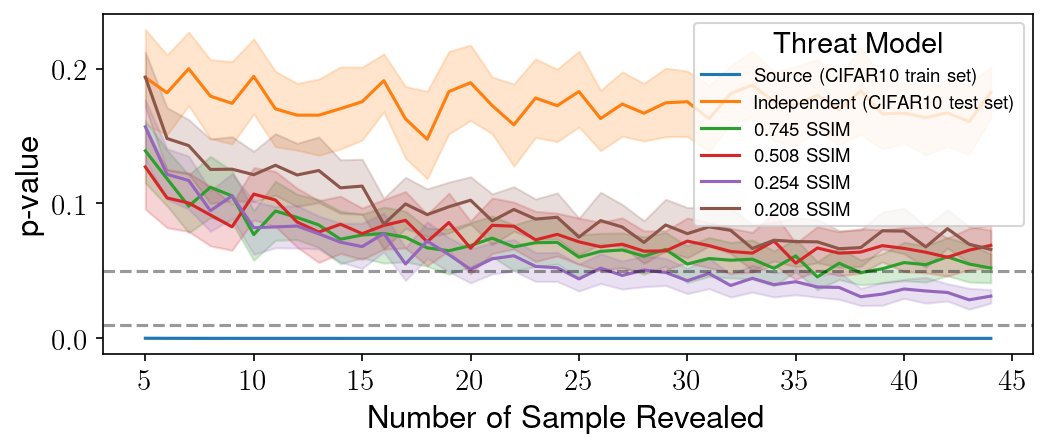

In [26]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")

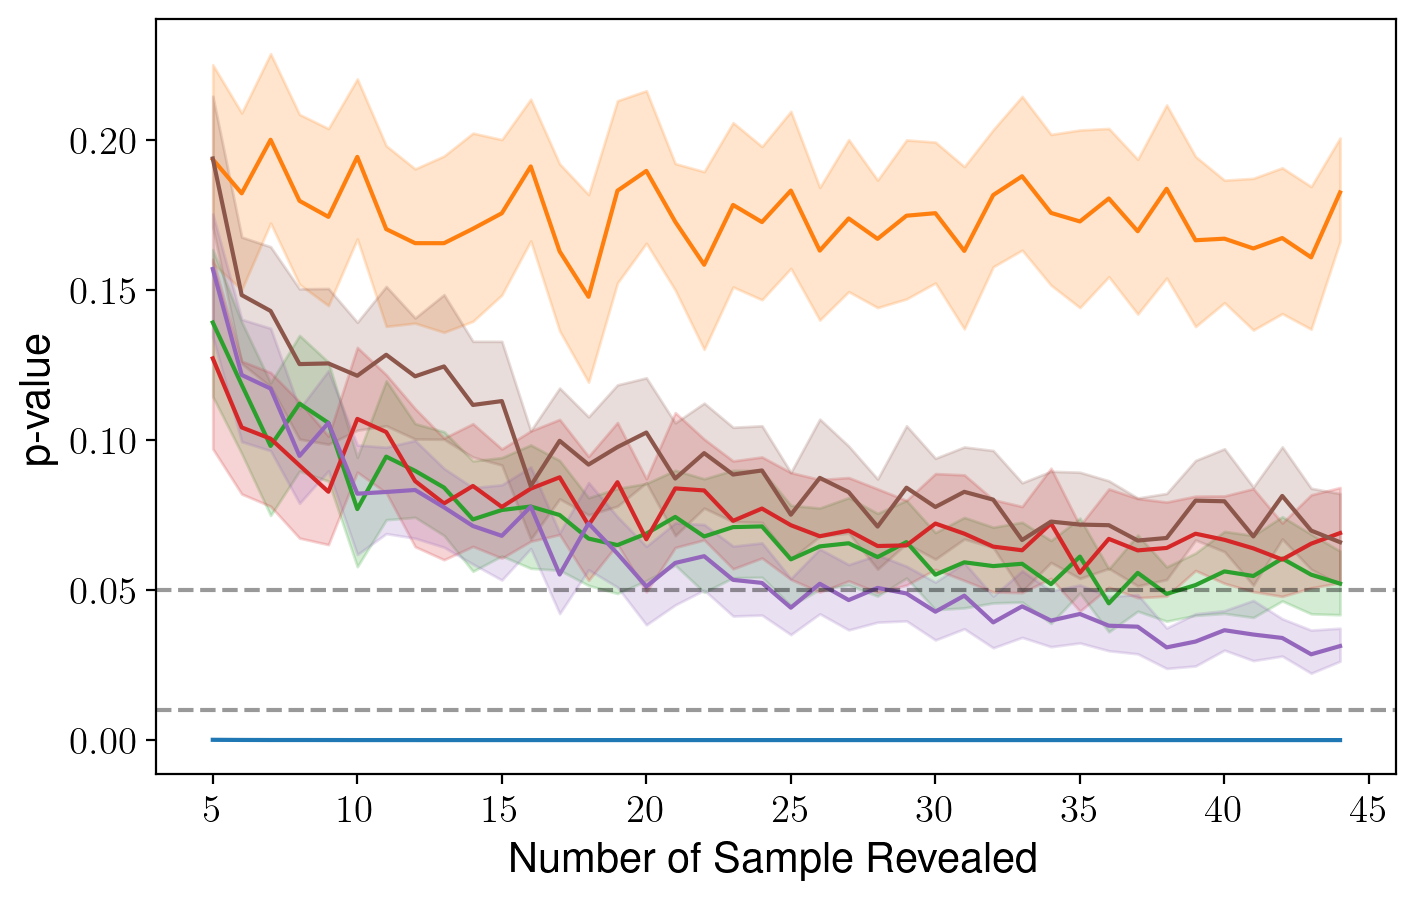

In [31]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")
# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
ax.get_legend().remove()

# ! Output graph
graph_dir_path = cwd_path / "fig"
graph_dir_path.mkdir(exist_ok=True)
fig.savefig(
    fname=graph_dir_path / f"SSIM_CIFAR10_{v_type}.png",
    transparent=False,
    bbox_inches="tight",
)

# Table

In [28]:
from utils import generate_table
tab = generate_table(selected_m=10, outputs_te=outputs_te, outputs_tr=outputs_tr, names=names)

ImportError: cannot import name 'generate_table' from 'utils' (/data/weijing/author-DI/src/utils/__init__.py)

In [ ]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab)

               mean_diff  p_value
teacher            0.838    0.000
distillation       0.586    0.000
pre-act-18         0.645    0.000
zero-shot          0.371    0.024
fine-tune          0.832    0.000
extract-label      0.475    0.001
extract-logit      0.563    0.001
independent        0.103    1.000


In [ ]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab.to_latex(formatters=dict(mean_diff="{:0.3f}".format, p_value=lambda x: "$10^{"+f"{x:0.0E}"[2:]+"}$"), escape=False))

\begin{tabular}{lrr}
\toprule
{} & mean_diff &    p_value \\
\midrule
teacher       &     0.838 & $10^{-04}$ \\
distillation  &     0.586 & $10^{-04}$ \\
pre-act-18    &     0.645 & $10^{-04}$ \\
zero-shot     &     0.371 & $10^{-02}$ \\
fine-tune     &     0.832 & $10^{-05}$ \\
extract-label &     0.475 & $10^{-03}$ \\
extract-logit &     0.563 & $10^{-03}$ \\
independent   &     0.103 & $10^{+00}$ \\
\bottomrule
\end{tabular}

